In [1]:
import sys, os

sys.path.append(os.path.abspath("../"))

In [2]:
import pandas as pd
from datetime import timedelta
import numpy as np
import json

with open('../data/aapl_options_iv.json', 'r') as f:
    data = json.load(f)

In [3]:
from src.models.iv import SA_IV_cal
from src.models.iv import SAIVCal
from scipy.optimize import Bounds

## 1day exp

In [4]:
lnK = np.array(data[0]["Call_IV"]['lnK']+data[0]["Put_IV"]['lnK'])
otm_iv = np.array(data[0]["Call_IV"]['otm_iv']+data[0]["Put_IV"]['otm_iv'])

init_param = (-0.95, 0.05, 0.005)
sa_iv_cal = SAIVCal(init_param, pp=lnK.max()+0.1, pm=lnK.min()-1)
fit_param = sa_iv_cal.calibration(pb_low=np.array([-0.95, 0.05, 0.005]),
                                pb_high=np.array([0.95, 50.0, 4]),
                                data=(lnK, otm_iv))

`xtol` termination condition is satisfied.
Function evaluations 16, initial cost 2.8560e+02, final cost 1.5937e+02, first-order optimality 2.94e+04.
Stop reason: `xtol` termination condition is satisfied.


In [5]:
print(fit_param)

[-0.94717887  0.78962954  2.72329171]


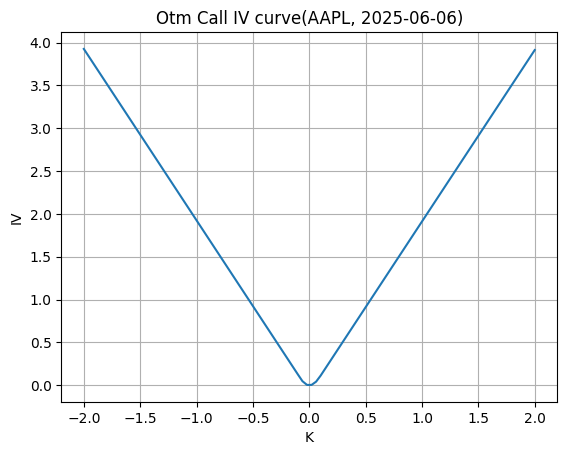

In [6]:
import matplotlib.pyplot as plt
# plt.plot(us, sa_iv_cal.IV_curve(param=[-.04, 0.2, 0.04], lnK=us))
us = np.linspace(-2, 2, 100)
Lambda = sa_iv_cal.Lambda([0.4, 0.2, 0.04], us)
plt.plot(us, sa_iv_cal.rate_function(us, us, Lambda))
plt.title("Otm Call IV curve(AAPL, 2025-06-06)")
plt.xlabel("K")
plt.ylabel("IV")
plt.grid()
plt.show()

In [7]:
print(sa_iv_cal.pm, sa_iv_cal.pp)

-1.6163643053695043 0.5669805111678171


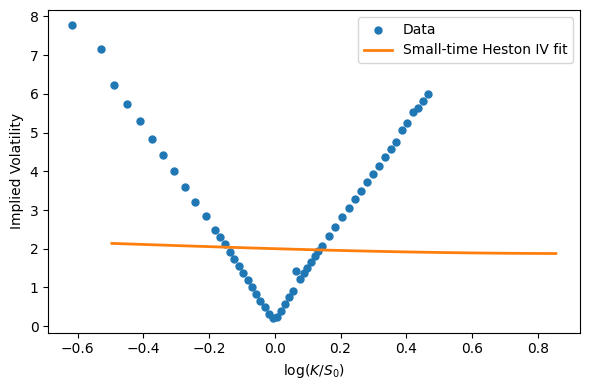

In [17]:
# Example usage (assuming you have lnK and iv as 1D numpy arrays):
from src.models.iv_test import HestonSmallTimeIV
param = (-0.4, 5, 2)
model = HestonSmallTimeIV(param, None, None)
fitted_iv = model.IV_curve(param, lnK)
model.plot(param, lnK, otm_iv)

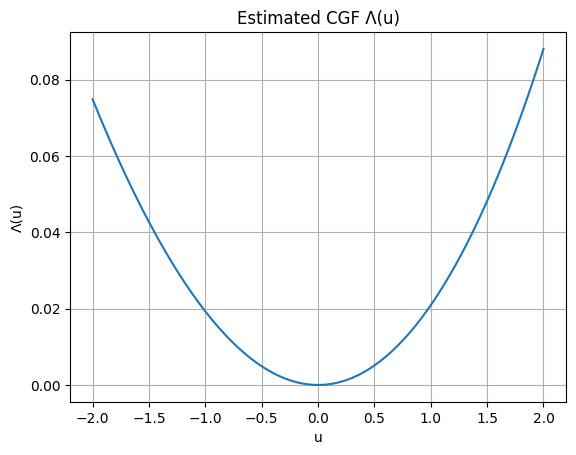

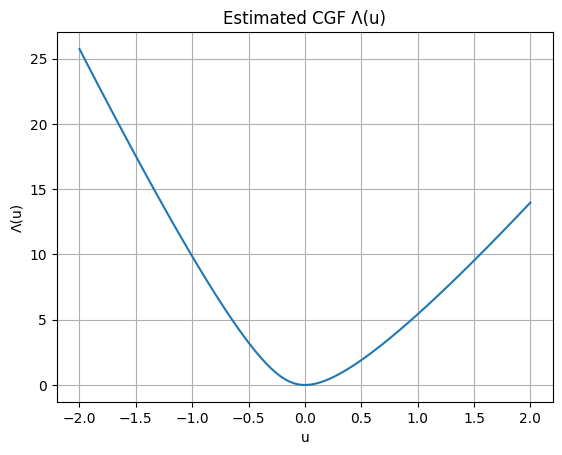

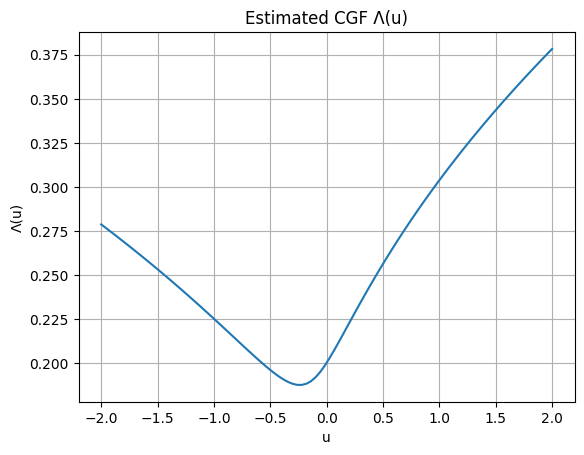

In [15]:
us = np.linspace(-2, 2, 100)
# plt.plot(us, sa_iv_cal.IV_curve(param=[-.04, 0.2, 0.04], lnK=us))
plt.plot(us, [model.Lambda([0.4, 0.2, 0.2], u) for u in us])
plt.title("Estimated CGF Λ(u)")
plt.xlabel("u")
plt.ylabel("Λ(u)")
plt.grid()
plt.show()

plt.plot(us, [model.legendre_transform([0.4, 0.2, 0.2], u) for u in us])
plt.title("Estimated CGF Λ(u)")
plt.xlabel("u")
plt.ylabel("Λ(u)")
plt.grid()
plt.show()

plt.plot(us, model.IV_curve([0.4, 0.2, 0.2], us))
plt.title("Estimated CGF Λ(u)")
plt.xlabel("u")
plt.ylabel("Λ(u)")
plt.grid()
plt.show()

In [18]:
from scipy.optimize import least_squares

In [49]:
def residuals(params, x, market_iv):
    rho, sigma, y0 = params
    model_iv = model.IV_curve([rho, sigma, y0], x)
    return model_iv - market_iv

def calibrate_iv_smile(x, market_iv, initial_guess=(0.0, 0.2, 0.4)):
    abs_x = np.abs(x)
    res = least_squares(residuals, initial_guess, bounds=([-0.999, 1e-6, 1e-6], [0.999, 300, 1]), args=(x, market_iv))
    rho, sigma, y0 = res.x
    return rho, sigma, y0, res

In [50]:
lnK = np.array(data[0]["Call_IV"]['lnK'])
otm_iv = np.array(data[0]["Call_IV"]['otm_iv'])

rho, sigma, y0, res = calibrate_iv_smile(lnK, otm_iv)
np.mean(res.fun**2)

np.float64(0.375825646637228)

In [51]:
rho, sigma, y0

(np.float64(0.8479143785484526),
 np.float64(218.4315732945303),
 np.float64(0.001475580834802594))

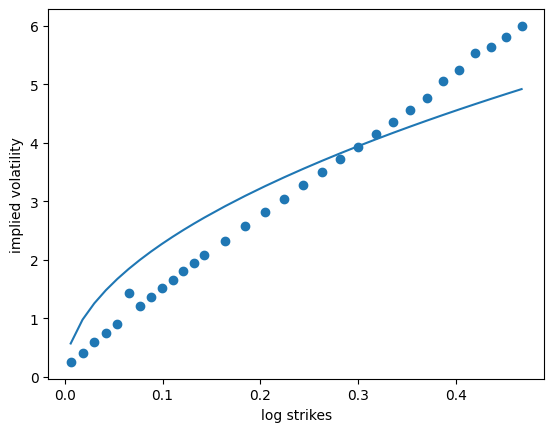

In [52]:
plt.scatter(lnK, otm_iv)
# plt.plot(np.log(K_call/S0), implied_vol_smile(np.log(K_call/S0), rho, sigma, np.sqrt(y0)), '-')
us = np.linspace(-0.1, 0.1, 100)
plt.plot(lnK, model.IV_curve([rho, sigma, y0], lnK))
# plot for all call implied volatility is not 0
plt.xlabel('log strikes')
plt.ylabel('implied volatility')
plt.show()

In [53]:
lnK = np.array(data[1]["Call_IV"]['lnK'])
otm_iv = np.array(data[1]["Call_IV"]['otm_iv'])

rho, sigma, y0, res = calibrate_iv_smile(lnK, otm_iv)
np.mean(res.fun**2)

np.float64(0.008586106196504613)

In [55]:
rho, sigma, y0

(np.float64(-0.5639571580365764),
 np.float64(19.795020549204636),
 np.float64(1.937709062080002e-05))

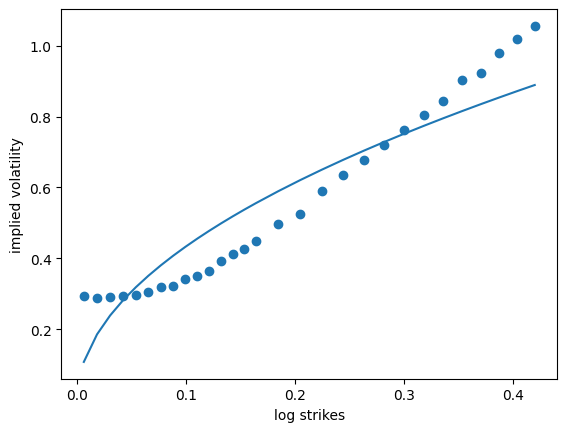

In [54]:
plt.scatter(lnK, otm_iv)
# plt.plot(np.log(K_call/S0), implied_vol_smile(np.log(K_call/S0), rho, sigma, np.sqrt(y0)), '-')
us = np.linspace(-0.1, 0.1, 100)
plt.plot(lnK, model.IV_curve([rho, sigma, y0], lnK))
# plot for all call implied volatility is not 0
plt.xlabel('log strikes')
plt.ylabel('implied volatility')
plt.show()